# mlreflect usage example

In [1]:
%load_ext autoreload

In [3]:
import matplotlib.pyplot as plt
import numpy as np

import mlreflect

from mlreflect import ReflectivityGenerator, InputPreprocessor, OutputPreprocessor, Prediction, Layer, MultilayerStructure
from mlreflect import h5_tools
from mlreflect.models.simple_model import SimpleModel
from mlreflect.models.model_helpers import create_save_directory

print('Tested with mlreflect version: ' + mlreflect.__version__)

Tested with mlreflect version: 0.12.0


### Load experimental data
In this case DIP_303K.txt contains columns of reflectivity data with the first column containing the q-values in units 1/A

In [4]:
experiment = np.loadtxt('DIP_303K.txt')

In [5]:
q = experiment[9:, 0] # Extract q-values
experimental_reflectivity = experiment[9:, 1:].T

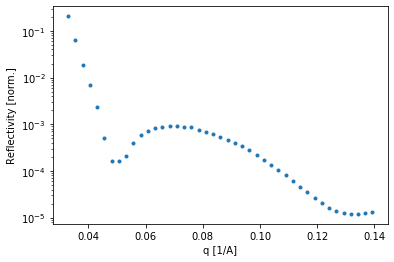

In [6]:
plt.semilogy(q, experimental_reflectivity[30, :], '.')
plt.xlabel('q [1/A]')
plt.ylabel('Reflectivity [norm.]')
plt.show()

### Generate random training data
Choose parameter ranges for the randomly generated training data with mininimum and maximum values for each layer using Layer objects.

In [7]:
layer1 = Layer('Si', (None, None), (1, 1), (20.1, 20.1))
layer2 = Layer('SiOx', (2.8, 30), (2.5, 2.5), (17.8, 17.8))
layer3 = Layer('Film', (20, 300), (0, 60), (1, 14))

The layers are then added to a MultilayerStructure

In [8]:
sample = MultilayerStructure(ambient_sld=0) # Initialize MultilayerStructure object with ambient SLD of 0 (air for X-ray)
sample.add_layer(layer1)
sample.add_layer(layer2)
sample.add_layer(layer3)

In [9]:
print(sample)

ambient_sld: 0 [1e-6 1/Å^2]
[2] Film:
	thickness: 20 -- 300 [Å]
	roughness: 0 -- 60 [Å]
	sld: 1 -- 14 [1e-6 1/Å^2]
[1] SiOx:
	thickness: 2.8 -- 30 [Å]
	roughness: 2.5 -- 2.5 [Å]
	sld: 17.8 -- 17.8 [1e-6 1/Å^2]
[0] Si:
	thickness: None -- None [Å]
	roughness: 1 -- 1 [Å]
	sld: 20.1 -- 20.1 [1e-6 1/Å^2]



In [10]:
gen = ReflectivityGenerator(q, sample) # Initialize ReflectivityGenerator using the previously constructed sample
random_labels = gen.generate_random_labels(22500)

Finished 'generate_random_labels' in 0.1511 secs


In [11]:
random_labels[0:4] # Quick inspection if the generated parameters are as expected

,Si_thickness,SiOx_thickness,Film_thickness,Si_roughness,SiOx_roughness,Film_roughness,Si_sld,SiOx_sld,Film_sld
0,1.0,18.586665,273.018171,1.0,2.5,5.661025,20.1,17.8,6.948613
1,1.0,15.757396,162.503923,1.0,2.5,18.080997,20.1,17.8,5.831749
2,1.0,5.920091,23.222848,1.0,2.5,0.796359,20.1,17.8,8.686909
3,1.0,8.040882,255.509604,1.0,2.5,9.326981,20.1,17.8,13.599900


In [12]:
random_reflectivity = gen.simulate_reflectivity(random_labels) # Simulate reflectivity using the generated parameters

100%|██████████| 22500/22500 [00:16<00:00, 1334.77it/s]

Finished 'simulate_reflectivity' in 16.8945 secs


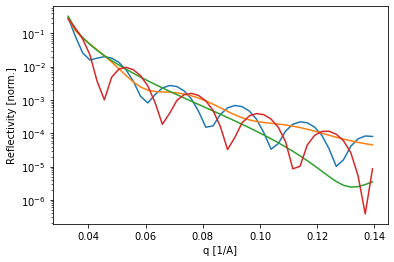

In [13]:
plt.semilogy(q, random_reflectivity[0, :])
plt.semilogy(q, random_reflectivity[1, :])
plt.semilogy(q, random_reflectivity[2, :])
plt.semilogy(q, random_reflectivity[3, :])
plt.xlabel('q [1/A]')
plt.ylabel('Reflectivity [norm.]')
plt.show()

In [14]:
sld_profiles = gen.simulate_sld_profiles(random_labels) # Simulate SLD profile for visual inspection

100%|██████████| 22500/22500 [00:06<00:00, 3311.89it/s]

Finished 'simulate_sld_profiles' in 6.7962 secs


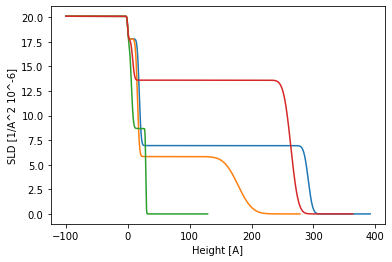

In [15]:
plt.plot(sld_profiles[0][0, :], sld_profiles[0][1, :])
plt.plot(sld_profiles[1][0, :], sld_profiles[1][1, :])
plt.plot(sld_profiles[2][0, :], sld_profiles[2][1, :])
plt.plot(sld_profiles[3][0, :], sld_profiles[3][1, :])
plt.xlabel('Height [A]')
plt.ylabel('SLD [1/A^2 10^-6]')
plt.show()

Split labels and reflectivity into training, validation and testing sets. Since labels are saved as a pandas DataFrame, the index must be dropped.

In [16]:
train_labels = random_labels[:20000].reset_index(drop=True)
val_labels = random_labels[20000:22000].reset_index(drop=True)
test_labels = random_labels[22000:].reset_index(drop=True)

In [17]:
train_reflectivity = random_reflectivity[:20000, :]
val_reflectivity = random_reflectivity[20000:22000, :]
test_reflectivity = random_reflectivity[22000:, :]

Write data to an h5 file so it can be reused later.

In [18]:
create_save_directory('output/')
h5_tools.save_data_as_h5('output/saved_training_data.h5', 'train', q, train_reflectivity, train_labels)
h5_tools.save_data_as_h5('output/saved_training_data.h5', 'val', q, val_reflectivity, val_labels)
h5_tools.save_data_as_h5('output/saved_training_data.h5', 'test', q, test_reflectivity, test_labels)

In [19]:
# loaded_data = h5_tools.read_from_h5('saved_training_data.h5', 'train') # Data can be loaded like this

### Train neural network

Initialize InputPreprocessor object and add jobs to the preprocessing list.

In [20]:
ip = InputPreprocessor()

ip.append_to_job_list(ip.log)
ip.append_to_job_list(ip.standardize)

Apply preprocessing to the input data.

In [21]:
train_reflectivity_pp = ip.apply_preprocessing(train_reflectivity)
val_reflectivity_pp = ip.apply_preprocessing(val_reflectivity)
test_reflectivity_pp = ip.apply_preprocessing(test_reflectivity)

Initialize OutputPreprocessor object with the predefined sample and apply preprocessing to the labels.

In [22]:
op = OutputPreprocessor(sample)

train_labels_pp = op.apply_preprocessing(train_labels)
val_labels_pp = op.apply_preprocessing(val_labels)
test_labels_pp = op.apply_preprocessing(test_labels)

Train the neural network using the model defined in SimpleModel and save results in 'output/simple_model/'.

In [23]:
simple_model = SimpleModel('output/simple_model/', train_reflectivity_pp.shape[1], train_labels_pp.shape[1])
hist = simple_model.train(train_reflectivity_pp, train_labels_pp, val_reflectivity_pp, val_labels_pp)




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 400)               17600     
_________________________________________________________________
activation_1 (Activation)    (None, 400)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 800)               320800    
_________________________________________________________________
activation_2 (Activation)    (None, 800)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 400)               320400    
_________________________________________________________________
activation_3 (Activation)    (None, 400)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 300)               120300    
_______

20000/20000 [==============================] - 0s 11us/step - loss: 0.0036 - val_loss: 0.0034

Epoch 00022: val_loss improved from 0.00402 to 0.00344, saving model to output/simple_model/models/2020-01-17-195659.h5
Epoch 23/60
20000/20000 [==============================] - 0s 10us/step - loss: 0.0035 - val_loss: 0.0037

Epoch 00023: val_loss did not improve from 0.00344
Epoch 24/60
20000/20000 [==============================] - 0s 10us/step - loss: 0.0036 - val_loss: 0.0058

Epoch 00024: val_loss did not improve from 0.00344
Epoch 25/60
20000/20000 [==============================] - 0s 11us/step - loss: 0.0036 - val_loss: 0.0043

Epoch 00025: val_loss did not improve from 0.00344
Epoch 26/60
20000/20000 [==============================] - 0s 12us/step - loss: 0.0034 - val_loss: 0.0040

Epoch 00026: val_loss did not improve from 0.00344
Epoch 27/60
20000/20000 [==============================] - 0s 11us/step - loss: 0.0033 - val_loss: 0.0043

Epoch 00027: val_loss did not improve from 0.0

Inspect training and validation loss.

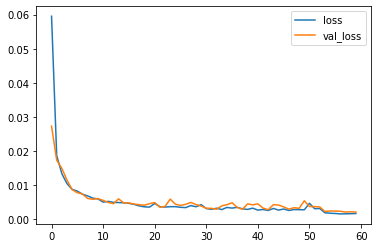

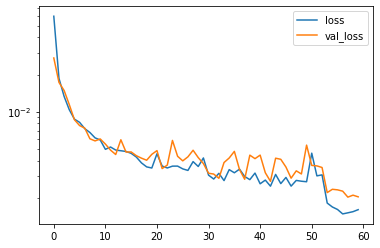

In [24]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.semilogy(hist.history['loss'], label='loss')
plt.semilogy(hist.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

### Test on simulated data

Initialize the Prediction object for the given model and labels.

In [25]:
timestamp = '2020-01-17-195659' # Timestamp needs to be adjusted to the one of the trained model
pr = Prediction('output/simple_model/models/' + timestamp + '.h5', op.used_label_names)

In [26]:
pred_test_labels = pr.predict_labels(test_reflectivity_pp) # Predict labels for simulated test data

Finished 'predict_labels' in 0.0696 secs


In [27]:
test_labels_pp # Inspect previously generated and preprocessed test labels

,SiOx_thickness,Film_thickness,Film_roughness,Film_sld
0,0.958561,0.089515,0.289704,0.136798
1,0.424415,0.902893,0.293485,0.549394
2,0.622017,0.097278,0.191505,0.204079
3,0.359463,0.782076,0.364184,0.674459
4,0.757525,0.889160,0.246260,0.692307
...,...,...,...,...
495,0.137838,0.017393,0.119280,0.559867
496,0.832893,0.174054,0.315083,0.123254
497,0.923483,0.965003,0.918648,0.454771
498,0.241530,0.736389,0.221555,0.800459


In [28]:
pred_test_labels # Inspect predicted test labels

,SiOx_thickness,Film_thickness,Film_roughness,Film_sld
0,0.950466,0.086208,0.270405,0.141304
1,0.434091,0.909180,0.291909,0.539140
2,0.612155,0.108703,0.193554,0.205437
3,0.344038,0.763091,0.354224,0.678641
4,0.729552,0.881447,0.246227,0.696534
...,...,...,...,...
495,0.284896,0.000000,0.083721,0.783175
496,0.855902,0.170378,0.282327,0.122445
497,0.918513,0.939348,0.923913,0.465172
498,0.253108,0.747320,0.217002,0.803725


In [29]:
pred_test_labels.reset_index(drop=True) - test_labels_pp.reset_index(drop=True) # Calculate absolute error

,SiOx_thickness,Film_thickness,Film_roughness,Film_sld
0,-0.008094,-0.003307,-0.019299,0.004506
1,0.009675,0.006287,-0.001576,-0.010254
2,-0.009862,0.011425,0.002048,0.001358
3,-0.015425,-0.018985,-0.009960,0.004181
4,-0.027973,-0.007713,-0.000033,0.004227
...,...,...,...,...
495,0.147058,-0.017393,-0.035559,0.223308
496,0.023010,-0.003676,-0.032756,-0.000809
497,-0.004970,-0.025655,0.005265,0.010401
498,0.011579,0.010931,-0.004553,0.003265


In [30]:
mae = pr.mean_absolute_error(pred_test_labels, test_labels_pp) # Calculate mean absolute error
print(mae)

SiOx_thickness    0.031515
Film_thickness    0.011913
Film_roughness    0.014923
Film_sld          0.018987
dtype: float64


In [31]:
mape = pr.mean_absolute_percentage_error(pred_test_labels, test_labels_pp) # Calculate mean absolute percentage error
print(mape)

SiOx_thickness    0.812078
Film_thickness    0.082397
Film_roughness    0.250862
Film_sld          0.065814
dtype: float64


In [32]:
test_labels # Inspect previously generated test labels

,Si_thickness,SiOx_thickness,Film_thickness,Si_roughness,SiOx_roughness,Film_roughness,Si_sld,SiOx_sld,Film_sld
0,1.0,28.872852,45.064113,1.0,2.5,17.382215,20.1,17.8,2.778370
1,1.0,14.344100,272.810166,1.0,2.5,17.609095,20.1,17.8,8.142122
2,1.0,19.718859,47.237805,1.0,2.5,11.490326,20.1,17.8,3.653029
3,1.0,12.577387,238.981324,1.0,2.5,21.851051,20.1,17.8,9.767969
4,1.0,23.404693,268.964842,1.0,2.5,14.775607,20.1,17.8,9.999991
...,...,...,...,...,...,...,...,...,...
495,1.0,6.549187,24.869964,1.0,2.5,7.156819,20.1,17.8,8.278267
496,1.0,25.454678,68.735152,1.0,2.5,18.904977,20.1,17.8,2.602305
497,1.0,27.918737,290.200891,1.0,2.5,55.118869,20.1,17.8,6.912025
498,1.0,9.369604,226.188839,1.0,2.5,13.293290,20.1,17.8,11.405973


In [33]:
restored_pred_test_labels = op.restore_labels(pred_test_labels, test_labels) # Reverse preprocessing on predicted test labels

In [34]:
restored_pred_test_labels # Inspect predicted test labels without preprocessing

,Si_thickness,SiOx_thickness,Film_thickness,Si_roughness,SiOx_roughness,Film_roughness,Si_sld,SiOx_sld,Film_sld
0,1.0,28.652685,44.138199,1.0,2.5,16.224272,20.1,17.8,2.836947
1,1.0,14.607272,274.570435,1.0,2.5,17.514534,20.1,17.8,8.008825
2,1.0,19.450624,50.436943,1.0,2.5,11.613225,20.1,17.8,3.670682
3,1.0,12.157836,233.665421,1.0,2.5,21.253437,20.1,17.8,9.822328
4,1.0,22.643824,266.805298,1.0,2.5,14.773638,20.1,17.8,10.054945
...,...,...,...,...,...,...,...,...,...
495,1.0,10.549170,20.000000,1.0,2.5,5.023251,20.1,17.8,11.181277
496,1.0,26.080547,67.705849,1.0,2.5,16.939644,20.1,17.8,2.591787
497,1.0,27.783546,283.017426,1.0,2.5,55.434761,20.1,17.8,7.047240
498,1.0,9.684545,229.249542,1.0,2.5,13.020091,20.1,17.8,11.448420


Compare test labels with predicted test labels.

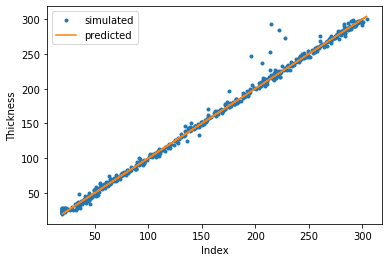

In [35]:
plt.plot(restored_pred_test_labels['Film_thickness'], test_labels['Film_thickness'], '.', label='simulated')
plt.plot(restored_pred_test_labels['Film_thickness'], restored_pred_test_labels['Film_thickness'], label='predicted')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Thickness')
plt.show()

Simulate reflectivity from predicted labels.

In [36]:
pred_test_reflectivity = gen.simulate_reflectivity(restored_pred_test_labels)

100%|██████████| 500/500 [00:00<00:00, 1285.48it/s]

Finished 'simulate_reflectivity' in 0.3915 secs


Plot test reflectivity with predicted reflectivity

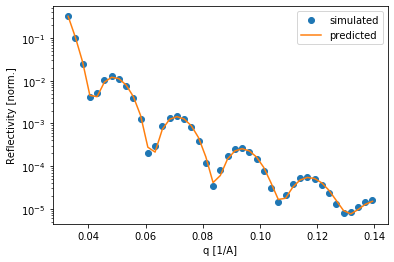

In [37]:
plt.semilogy(q, test_reflectivity[4, :], 'o', label='simulated')
plt.semilogy(q, pred_test_reflectivity[4, :], label='predicted')
plt.legend()
plt.xlabel('q [1/A]')
plt.ylabel('Reflectivity [norm.]')
plt.show()

### Test on experimental data

In [38]:
experimental_reflectivity_pp = ip.apply_preprocessing(experimental_reflectivity)

In [39]:
pred_experimental_test_labels = pr.predict_labels(experimental_reflectivity_pp) # Predict labels for experimental test data

Finished 'predict_labels' in 0.0038 secs


In [40]:
pred_experimental_test_labels

,SiOx_thickness,Film_thickness,Film_roughness,Film_sld
0,0.614196,0.575213,0.187552,0.015110
1,0.652215,0.499034,0.187930,0.051453
2,0.681738,0.313495,0.202775,0.088829
3,0.664503,0.234178,0.287632,0.142881
4,0.639296,0.055974,0.059981,0.194520
...,...,...,...,...
64,0.222610,0.455889,0.488168,0.839516
65,0.251390,0.472147,0.497866,0.842843
66,0.197913,0.477924,0.520720,0.855241
67,0.197042,0.491521,0.516336,0.859378


In [41]:
restored_pred_experimental_test_labels = op.restore_labels(pred_experimental_test_labels, test_labels) # Reverse preprocessing on predicted test labels

In [42]:
restored_pred_experimental_test_labels

,Si_thickness,SiOx_thickness,Film_thickness,Si_roughness,SiOx_roughness,Film_roughness,Si_sld,SiOx_sld,Film_sld
0,1.0,19.506130,181.059555,1.0,2.5,11.253111,20.1,17.8,1.196431
1,1.0,20.540258,159.729462,1.0,2.5,11.275818,20.1,17.8,1.668891
2,1.0,21.343262,107.778473,1.0,2.5,12.166486,20.1,17.8,2.154772
3,1.0,20.874475,85.569939,1.0,2.5,17.257915,20.1,17.8,2.857458
4,1.0,20.188864,35.672615,1.0,2.5,3.598879,20.1,17.8,3.528758
...,...,...,...,...,...,...,...,...,...
64,1.0,8.854997,147.649002,1.0,2.5,29.290085,20.1,17.8,11.913714
65,1.0,9.637809,152.201126,1.0,2.5,29.871979,20.1,17.8,11.956957
66,1.0,8.183232,153.818619,1.0,2.5,31.243172,20.1,17.8,12.118133
67,1.0,8.159533,157.625763,1.0,2.5,30.980186,20.1,17.8,12.171916


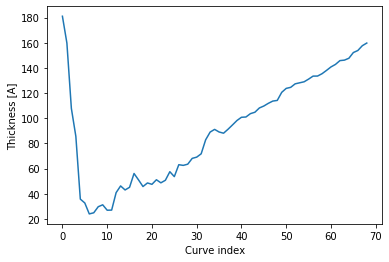

In [43]:
plt.plot(restored_pred_experimental_test_labels['Film_thickness'])
plt.xlabel('Curve index')
plt.ylabel('Thickness [A]')
plt.show()

In [44]:
pred_experimental_reflectivity = gen.simulate_reflectivity(restored_pred_experimental_test_labels)

100%|██████████| 69/69 [00:00<00:00, 1198.60it/s]

Finished 'simulate_reflectivity' in 0.0600 secs


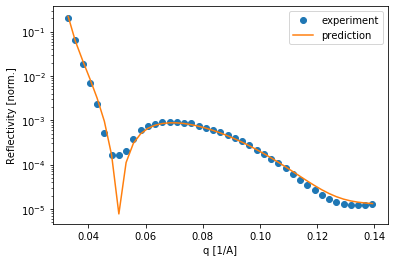

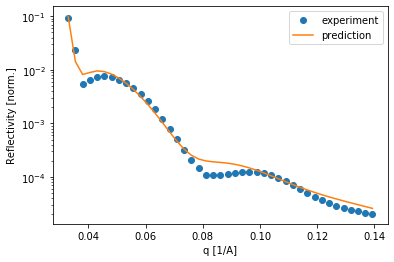

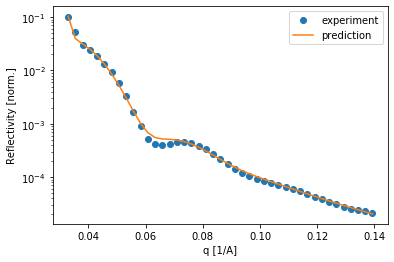

In [47]:
plt.semilogy(q, experimental_reflectivity[30, :], 'o', label='experiment')
plt.semilogy(q, pred_experimental_reflectivity[30, :], label='prediction')
plt.legend()
plt.xlabel('q [1/A]')
plt.ylabel('Reflectivity [norm.]')
plt.show()

plt.semilogy(q, experimental_reflectivity[50, :], 'o', label='experiment')
plt.semilogy(q, pred_experimental_reflectivity[50, :], label='prediction')
plt.legend()
plt.xlabel('q [1/A]')
plt.ylabel('Reflectivity [norm.]')
plt.show()

plt.semilogy(q, experimental_reflectivity[-1, :], 'o', label='experiment')
plt.semilogy(q, pred_experimental_reflectivity[-1, :], label='prediction')
plt.legend()
plt.xlabel('q [1/A]')
plt.ylabel('Reflectivity [norm.]')
plt.show()